# Code for Section 5.1.3 VaR and CVaR views
This notebook presents an elementary example of Entropy Pooling views on VaR and CVaR of S&P 500 and STOXX 50.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import fortitudo.tech as ft
import matplotlib.pyplot as plt

# S&P 500 and STOXX 50 data

In [2]:
tickers = ['^GSPC', '^STOXX50E']
data = yf.download(tickers, start='2007-03-30', end='2024-02-24')['Adj Close']
data.bfill(inplace=True)
column_names = ['S&P 500', 'STOXX 50']
data.columns = column_names

[*********************100%%**********************]  2 of 2 completed


In [3]:
R_df = pd.DataFrame(
    100 * (data.iloc[1:].values / data.iloc[0:-1].values - 1),
    columns=column_names)
S = len(R_df)

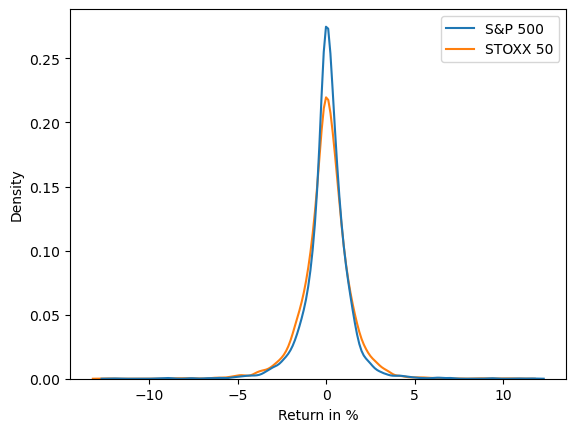

In [4]:
sns.kdeplot(R_df)
plt.xlabel('Return in %')
plt.show()

In [5]:
e_spx = np.array([[1], [0]])
e_stoxx = np.array([[0], [1]])
alpha = 90
var_prior_spx = ft.portfolio_var(e_spx, R_df, alpha=alpha / 100, demean=False)
cvar_prior_spx = ft.portfolio_cvar(e_spx, R_df, alpha=alpha / 100, demean=False)
var_prior_stoxx = ft.portfolio_var(e_stoxx, R_df, alpha=alpha / 100, demean=False)
cvar_prior_stoxx = ft.portfolio_cvar(e_stoxx, R_df, alpha=alpha / 100, demean=False)

In [6]:
print(f'Prior S&P 500 daily {alpha}%-VaR={np.round(var_prior_spx, 3)} and {alpha}%-CVaR={np.round(cvar_prior_spx, 3)}.')
print(f'Prior STOXX 50 daily {alpha}%-VaR={np.round(var_prior_stoxx, 3)} and {alpha}%-CVaR={np.round(cvar_prior_stoxx, 3)}.')

Prior S&P 500 daily 90%-VaR=1.241 and 90%-CVaR=2.332.
Prior STOXX 50 daily 90%-VaR=1.497 and 90%-CVaR=2.584.


# Entropy Pooling VaR and CVaR views
We specify the view that the S&P 500 VaR and CVaR are 50% higher than the prior and examine the effect for the distribution of both assets.

In [7]:
R = R_df.values
# VaR view row
pct_increase = 0.50
var_view_value = -var_prior_spx * (1 + pct_increase)
a = 1 * (R[:, 0] <= var_view_value)
# CVaR view row
cvar_row = a * R[:, 0]

In [8]:
# Specify Entropy Pooling constraints
A = np.vstack((np.ones(S), a, cvar_row))
cvar_view_value = -cvar_prior_spx * (1 + pct_increase)
b = np.array([[1.], [1 - alpha / 100], [(1 - alpha / 100) * cvar_view_value]])

In [9]:
# Compute posterior probability
p = np.ones((S, 1)) / S
q = ft.entropy_pooling(p, A, b)

In [10]:
# Compute effective number of scenarios to assess the magnitude of the stress-test
effective_number_scenarios = np.exp(-q.T @ (np.log(q) - np.log(p)))
print(f'Effective number of scenarios is {np.round(100 * effective_number_scenarios[0][0], 2)}%.')

Effective number of scenarios is 97.84%.


In [11]:
# Compute posterior S&P 500 VaR and CVaR
var_post_spx = ft.portfolio_var(e_spx, R_df, p=q, alpha=alpha / 100, demean=False)
cvar_post_spx = ft.portfolio_cvar(e_spx, R_df, p=q, alpha=alpha / 100, demean=False)

In [12]:
# Compute the difference in the view value and result
print(f'VaR view difference {np.round(var_post_spx + var_view_value, 4)}%.')
print(f'CVaR view difference {np.round(cvar_post_spx + cvar_view_value, 4)}%.')

VaR view difference 0.0013%.
CVaR view difference 0.0%.


# Plot prior and posterior distributions (Figure 5.1.1)

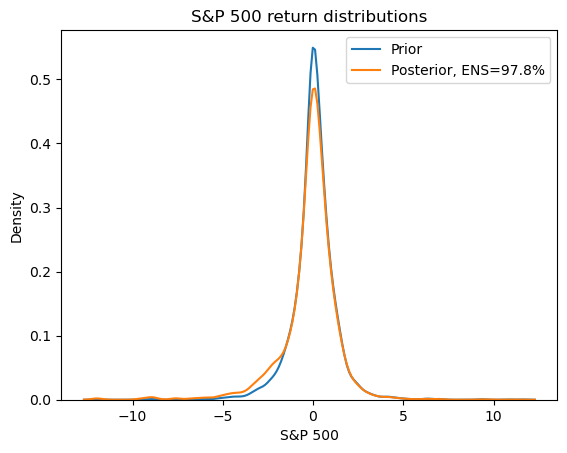

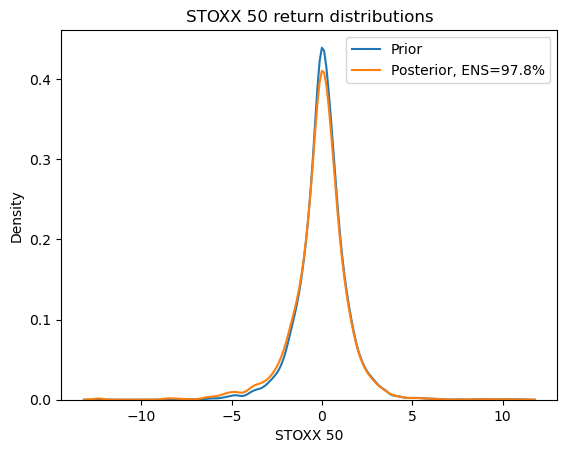

In [13]:
sns.kdeplot(x=R_df.iloc[:, 0])
sns.kdeplot(x=R_df.iloc[:, 0], weights=q[:, 0])
plt.title('S&P 500 return distributions')
plt.legend(['Prior',
            f'Posterior, ENS={100 * np.round(effective_number_scenarios[0, 0], 3)}%'])
plt.show()

sns.kdeplot(x=R_df.iloc[:, 1])
sns.kdeplot(x=R_df.iloc[:, 1], weights=q[:, 0])
plt.title('STOXX 50 return distributions')
plt.legend(['Prior',
            f'Posterior, ENS={100 * np.round(effective_number_scenarios[0, 0], 3)}%'])
plt.show()

In [ ]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.